In [37]:
using LinearAlgebra
using Distributions
using Random
using SparseArrays
using JLD2

include("../../Inversion/Plot.jl")
include("../../Inversion/KalmanInversion.jl")
include("../../Fluid/Darcy-2D.jl")


aug_forward (generic function with 1 method)

# 2D Darcy Flow

Consider the Darcy flow equation on the two-dimensional spatial domain $D=[0,1]^2$, which describes the pressure field $p(x)$ in a porous medium defined by a positive permeability field $a(x,\theta)$:

$$
\begin{align*}
    -\nabla \cdot (a(x, \theta) \nabla p(x)) &= f(x), \quad &&x\in D,\\
    p(x) &= 0, \quad &&x\in \partial D.
\end{align*}
$$

For simplicity, Dirichlet boundary conditions on the pressure are applied on $\partial D$. The fluid source field $f$ is defined as

$$
\begin{align*}
    f(x_1, x_2) = \begin{cases}
               1000 & 0 \leq x_2 \leq \frac{4}{6}\\
               2000 & \frac{4}{6} < x_2 \leq \frac{5}{6}\\
               3000 & \frac{5}{6} < x_2 \leq 1\\
            \end{cases}. 
\end{align*}
$$



The equation is solved by the finite difference method similar with the [one-dimensional Darcy flow problem](../Posterior/Darcy-1D.ipynb), where computational domain is discretized by a $N \times N$ uniform grid ($N=80$ for the present study).


## Random log-Gaussian Field

Assuming that $\log a(x, \theta)$ is a centred Gaussian with covariance 
$$\mathsf{C} = (-\Delta + \tau^2 )^{-d};$$
here $-\Delta$ denotes the Laplacian on $D$ subject to homogeneous Neumann boundary conditions on the space of spatial-mean zero functions, 
$\tau > 0$ denotes the inverse length scale of the random field and $d  > 0$ determines its regularity.
The Gaussian field can be represented by the Karhunen–Loève (KL) expansion

\begin{equation}
\label{eq:KL-2d}
    \log a(x,\theta) = \sum_{l\in K} \theta_{(l)}\sqrt{\lambda_l} \psi_l(x),
\end{equation}
where $K = \mathcal{Z}^{0+}\times\mathcal{Z}^{0+} \setminus \{0,0\}$, and the eigenpairs are of the form

$$
\begin{equation*}
    \psi_l(x) = \begin{cases}
                 \sqrt{2}\cos(\pi l_1 x_1)              & l_2 = 0\\
                 \sqrt{2}\cos(\pi l_2 x_2)              & l_1 = 0\\
                 2\cos(\pi l_1 x_1)\cos(\pi l_2 x_2)    & \textrm{otherwise}\\
                 \end{cases},
                 \qquad \lambda_l = (\pi^2 |l|^2 + \tau^2)^{-d}
\end{equation*}
$$

and $\theta_{(l)} \sim \mathcal{N}(0,1)$ i.i.d. The KL expansion can be rewritten as a sum over $\mathcal{Z}^{0+}$ rather than a lattice: 

$$
\begin{equation}
\label{eq:KL-1d}
    \log a(x,\theta) = \sum_{k\in \mathcal{Z}^{0+}} \theta_{(k)}\sqrt{\lambda_k} \psi_k(x),
\end{equation}
$$

where the eigenvalues $\lambda_k$ are in descending order.
In practice, we truncate this sum to $N_\theta$ terms, based on the
largest $N_\theta$ eigenvalues, and hence $\theta\in\mathcal{R}^{N_\theta}$.
 


## Inverse Problem Setup

For the inverse problem, we recover the log-permeability field $\log a_{{ref}}(x)$ from the observation 
$y_{ref}$, which consists of pointwise measurements of the 
pressure value $p(x)$ at $49$ equidistant points in the domain. 


We generate a truth random field $\log a_{{ref}}(x)$ with $\theta \sim \mathcal{N}(0, I)$ in $\mathcal{R}^{128}$ 
(i.e. we use the first $128$ KL modes) to construct the observation $y_{obs}$.


In [38]:
#=
A hardcoding source function, 
which assumes the computational domain is
[0 1]×[0 1]
f(x,y) = f(y),
which dependes only on y
=#
function compute_f_2d(yy::Array{FT, 1}) where {FT<:AbstractFloat}
    N = length(yy)
    f_2d = zeros(FT, N, N)

    for i = 1:N
            f_2d[:,i] .= 1000.0 * sin(4pi*yy[i])
    end
    return f_2d
end


function generate_θ_KL(xx::Array{FT,1}, N_KL::IT, d::FT=2.0, τ::FT=3.0; seed::IT=123) where {FT<:AbstractFloat, IT<:Int}
    N = length(xx)
    X,Y = repeat(xx, 1, N), repeat(xx, 1, N)'
    
    seq_pairs = compute_seq_pairs(N_KL)
    
    φ = zeros(FT, N_KL, N, N)
    λ = zeros(FT, N_KL)
    
    for i = 1:N_KL
        if (seq_pairs[i, 1] == 0 && seq_pairs[i, 2] == 0)
            φ[i, :, :] .= 1.0
        elseif (seq_pairs[i, 1] == 0)
            φ[i, :, :] = sqrt(2)*cos.(pi * (seq_pairs[i, 2]*Y))
        elseif (seq_pairs[i, 2] == 0)
            φ[i, :, :] = sqrt(2)*cos.(pi * (seq_pairs[i, 1]*X))
        else
            φ[i, :, :] = 2*cos.(pi * (seq_pairs[i, 1]*X)) .*  cos.(pi * (seq_pairs[i, 2]*Y))
        end

        λ[i] = (pi^2*(seq_pairs[i, 1]^2 + seq_pairs[i, 2]^2) + τ^2)^(-d)
    end
    
    Random.seed!(seed);
#     rng = MersenneTwister(seed)
#     θ_ref = rand(rng, Normal(0, 10), N_KL)
    θ_ref = rand(Normal(0, 10), N_KL)
    
    logκ_2d = zeros(FT, N, N)
    for i = 1:N_KL
        logκ_2d .+= θ_ref[i]*sqrt(λ[i])*φ[i, :, :]
    end
    
    return logκ_2d, φ, λ, θ_ref
end

#=
Compute observation values
=#
function compute_obs(darcy::Setup_Param{FT, IT}, h_2d::Array{FT, 2}) where {FT<:AbstractFloat, IT<:Int}
    # X---X(1)---X(2) ... X(obs_N)---X
    obs_2d = h_2d[darcy.x_locs, darcy.y_locs] 
    
    Nx_o, Ny_o = size(obs_2d)
    
    obs_2d_sym = (obs_2d[1:div(Nx_o+1, 2), :] + obs_2d[end:-1:div(Nx_o, 2)+1, :]) / 2.0
    
    # obs_2d_sym = (obs_2d[:, 1:div(Ny_o+1, 2)] + obs_2d[:, end:-1:div(Ny_o, 2)+1]) / 2.0
    
    return obs_2d_sym[:]
end


function plot_field(darcy::Setup_Param{FT, IT}, u_2d::Array{FT, 2}, plot_obs::Bool,  filename::String = "None") where {FT<:AbstractFloat, IT<:Int}
    N = darcy.N
    xx = darcy.xx

    X,Y = repeat(xx, 1, N), repeat(xx, 1, N)'
    pcolormesh(X, Y, u_2d, cmap="viridis")
    colorbar()

    if plot_obs
        x_obs, y_obs = X[darcy.x_locs[1:div(length(darcy.x_locs)+1,2)], darcy.y_locs][:], Y[darcy.x_locs[1:div(length(darcy.x_locs)+1,2)], darcy.y_locs][:] 
        scatter(x_obs, y_obs, color="black")
        
        x_obs, y_obs = X[darcy.x_locs[div(length(darcy.x_locs)+1,2)+1:end], darcy.y_locs][:], Y[darcy.x_locs[div(length(darcy.x_locs)+1,2)+1:end], darcy.y_locs][:] 
        scatter(x_obs, y_obs, color="black", facecolors="none")
    end

    tight_layout()
    if filename != "None"
        savefig(filename)
    end
end

plot_field (generic function with 3 methods)

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


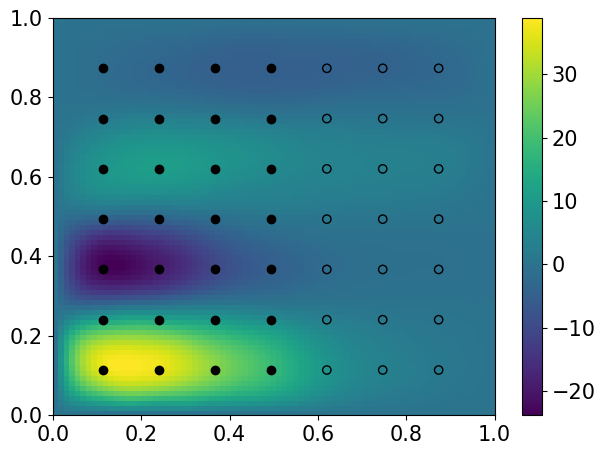

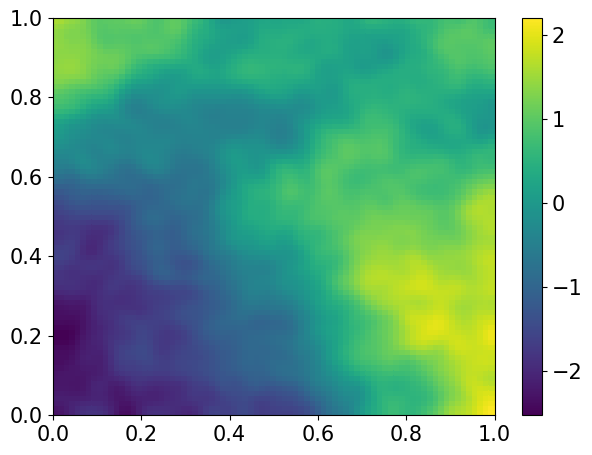

In [39]:
N, L = 80, 1.0
obs_ΔN = 10
d = 2.0
τ = 3.0
N_KL = 1024
N_θ = 0
darcy = Setup_Param(N, L, N_KL, obs_ΔN, N_θ, d, τ)



κ_2d = exp.(darcy.logκ_2d)
h_2d = solve_Darcy_2D(darcy, κ_2d)
y_noiseless = compute_obs(darcy, h_2d)

figure(1)
plot_field(darcy, h_2d, true, "Darcy-2D-obs.pdf")
figure(2)
plot_field(darcy, darcy.logκ_2d, false, "Darcy-2D-logk-ref.pdf")
    

## Inverse Problem Setup : Optimization Approach


$$
\begin{equation}
    y_{obs} = y_{ref} + \eta,
\end{equation}
$$

where $\eta = \mathcal{N}(0, I)$, and prior is $\mathcal{N}(0, 10^2I)$. Using this data, we consider the incomplete parameterization scenario, where we solve for the first $32$ KL modes  
        

In [52]:
# initial mean and covariance
# UKI
N_y = length(y_noiseless)
σ_η = 1.0^2
Σ_η = σ_η^2 * Array(Diagonal(fill(1.0, N_y)))
Random.seed!(123);
y = y_noiseless + rand(Normal(0, σ_η), N_y)

update_freq = 1
N_iter = 50
α_reg  = 1.0

N_θ = darcy.N_θ = 64
μ_0 = zeros(Float64, N_θ)  # prior/initial mean 
Σ_0 = Array(Diagonal(fill(10.0^2, N_θ)))  # prior/initial covariance

aug_y     = [y; μ_0] 
aug_Σ_η   = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ_0]  
darcy.N_y = (N_y + N_θ)

92

## UKI

In [53]:
# initial mean and covariance
# UKI
Random.seed!(123);
σ_0 = 10
θ0_mean = -rand(Normal(0, σ_0), N_θ) 
@show θ0_mean
θθ0_cov = Array(Diagonal(fill(1.0^2, N_θ)))

γ = 1.0
ukiobj = UKI_Run(darcy,  aug_forward, θ0_mean, θθ0_cov, μ_0, Σ_0, aug_y, aug_Σ_η, γ,  α_reg, update_freq, N_iter+1; unscented_transform = "modified-2n+1");
@info "Finish modified-2n+1"


N_ens = 2N_θ + 1
fig, (ax1, ax2, ax3) = PyPlot.subplots(ncols=3, figsize=(16,5))
ites = Array(LinRange(0, N_iter, N_iter+1))
errors = zeros(Float64, (3, N_iter+1, 4))
# UKI-1
for i = 1:N_iter+1
    errors[1, i, 1] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, ukiobj.θ_mean[i]))/norm(darcy.logκ_2d)
    errors[2, i, 1] = 0.5*(ukiobj.y_pred[i] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i] - ukiobj.y))
    errors[3, i, 1] = norm(ukiobj.θθ_cov[i])
end

ax1.plot(ites, errors[1, :, 1], "-.x", color = "C0", fillstyle="none", markevery=1, label= "UKI-1 (J=$N_ens)")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Rel. error of loga")
ax1.legend()

ax2.plot(ites, errors[2, :, 1], "-.x",  color = "C0", fillstyle="none", markevery=1, label= "UKI-1 (J=$N_ens)")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Optimization error")
ax2.legend()

ax3.plot(ites, errors[3, :, 1], "-.x",  color = "C0", fillstyle="none", markevery=1, label= "UKI-1 (J=$N_ens)")
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Frobenius norm of covariance")
ax3.legend()
fig.tight_layout()


# visulize the log permeability field
fig_logk, ax_logk = PyPlot.subplots(ncols = 3, sharex=true, sharey=true, figsize=(15,5))
for ax in ax_logk ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(darcy.logκ_2d), maximum(darcy.logκ_2d))

plot_field(darcy, darcy.logκ_2d, color_lim, ax_logk[1]) 


plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[N_iter]),  color_lim, ax_logk[2]) 


plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[1]),  color_lim, ax_logk[3]) 



fig_logk.tight_layout()
# fig_logk.savefig("Darcy-2D-logk-LR.pdf")




θ0_mean = [6.457306721039767, 14.632513788889215, 16.236037455860806, 2.176651067835462, -4.922456865251828, -9.809798121241487, -0.799568295050599, -15.491245530427918, 13.416092408832219, -4.121616346829679, -5.931973881209758, 7.68408918731307, 0.7616794545243701, 6.549005736319278, -6.870603731947982, 1.1946490783390415, -2.060750560105725, 10.190142181952096, -5.053106074828993, 5.382979349121415, -2.614008186093681, 13.11999766014946, 12.754423431732825, -3.884072457780736, -1.0901803311064597, -2.735893225022748, -0.5709742373655633, -3.9914981968163232, 1.5565118544328105, -17.92328334465374, -4.843286384137586, 2.024102293969917, 10.88218513936287, -7.037583257923017, -1.4332589323751366, -1.4837536667608195, -10.096134137351438, -0.28766636052271793, -1.707967032029406, 17.171200973796243, -11.067814366003583, -11.486968319829451, -6.15739830679831, 16.515960188538127, -2.1813966177530193, -15.486684918244734, 19.4328966619293, 17.433292819144075, -2.282463107729077, -5.94220

LoadError: AssertionError: Δt > 0.0 && Δt < 1

## GMKI

In [54]:
# compute posterior distribution by UKI
update_freq = 1
N_modes = 3
θ0_w  = fill(1.0, N_modes)/N_modes
θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)



Random.seed!(63);
σ_0 = 10
θ0_mean[1, :]    .= rand(Normal(0, σ_0), N_θ) 
θθ0_cov[1, :, :] .= Array(Diagonal(fill(1.0^2, N_θ)))
θ0_mean[2, :]    .= rand(Normal(0, σ_0), N_θ) 
θθ0_cov[2, :, :] .= Array(Diagonal(fill(1.0^2, N_θ)))
θ0_mean[3, :]    .= rand(Normal(0, σ_0), N_θ) 
θθ0_cov[3, :, :] .= Array(Diagonal(fill(1.0^2, N_θ)))





γ = 1.0
# Δt = γ/(1+γ)
ukiobj = GMUKI_Run(darcy, aug_forward, θ0_w, θ0_mean, θθ0_cov, aug_y, aug_Σ_η, γ, update_freq, N_iter; unscented_transform="modified-2n+1")
    

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82


GMUKIObj{Float64, Int64}(["logκ"], [[-1.0986122886681098, -1.0986122886681098, -1.0986122886681098], [-10.0, 0.0, -10.0], [-10.0, -3.885780586187972e-14, -10.0], [-10.0, -1.1422095896540991e-5, -10.0], [-9.941034076874931, -4.9099825978809484e-5, -10.0], [-9.701419241451331, -0.009451632573605729, -4.672816495970321], [-8.730674347823173, -0.331486781312827, -1.2659091983417607], [-7.284122796742838, -1.0470748652377135, -0.43332339081878746], [-5.4692905381192425, -1.4007180317228634, -0.2885280087940348], [-3.9551151664340534, -1.4187925141307272, -0.3026773033042058]  …  [-0.8784868447157894, -10.0, -0.5368462732743442], [-0.8784349199809197, -10.0, -0.5368831727860067], [-0.8783719374115545, -10.0, -0.536927934825567], [-0.8782985481563167, -10.0, -0.5369800989957348], [-0.8782230421990551, -10.0, -0.5370337745736524], [-0.8781442486160922, -10.0, -0.537089794606697], [-0.8780690364938051, -10.0, -0.5371432754159142], [-0.8779946034007854, -10.0, -0.5371962090125483], [-0.877927549

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


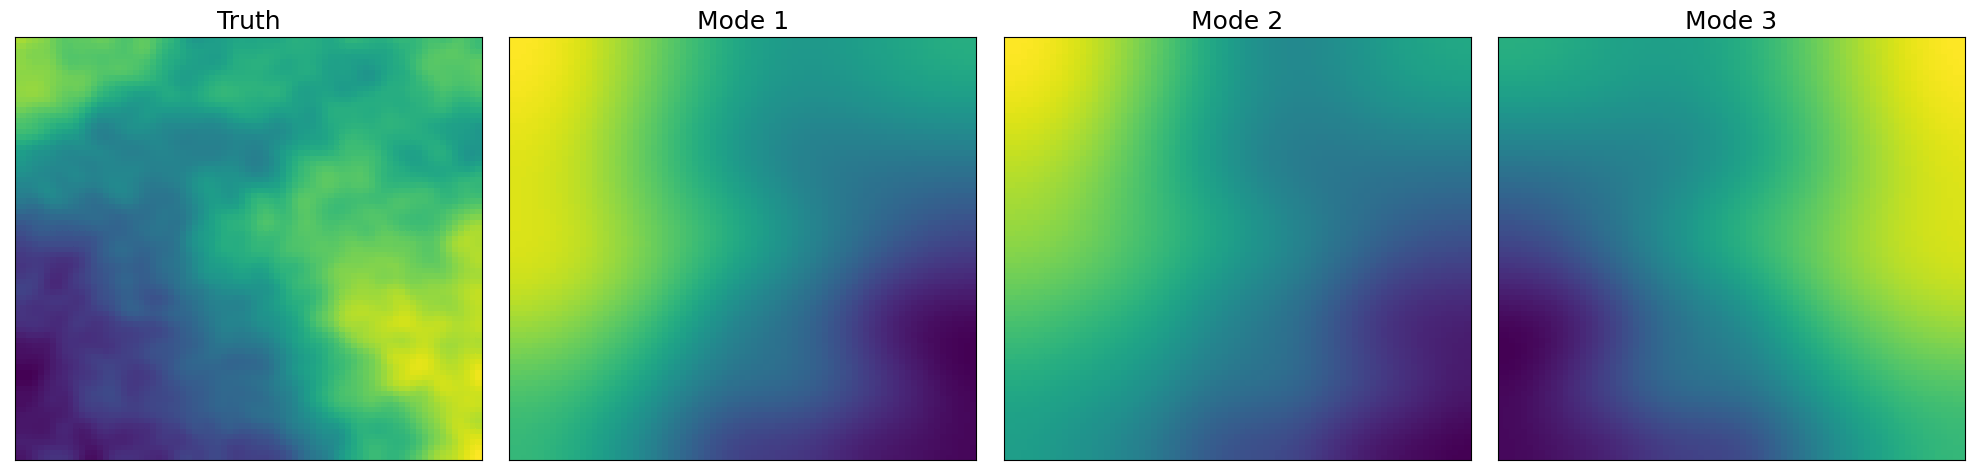

In [55]:
N_ens = 2N_θ + 1
# fig, (ax1, ax2, ax3) = PyPlot.subplots(ncols=3, figsize=(16,5))
# ites = Array(LinRange(0, N_iter, N_iter+1))
# errors = zeros(Float64, (3, N_iter+1, 4))
# # UKI-1
# for i = 1:N_iter+1
#     errors[1, i, 1] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, ukiobj.θ_mean[i]))/norm(darcy.logκ_2d)
#     errors[2, i, 1] = 0.5*(ukiobj.y_pred[i] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i] - ukiobj.y))
#     errors[3, i, 1] = norm(ukiobj.θθ_cov[i])
# end

# ax1.plot(ites, errors[1, :, 1], "-.x", color = "C0", fillstyle="none", markevery=1, label= "UKI-1 (J=$N_ens)")
# ax1.set_xlabel("Iterations")
# ax1.set_ylabel("Rel. error of loga")
# ax1.legend()

# ax2.plot(ites, errors[2, :, 1], "-.x",  color = "C0", fillstyle="none", markevery=1, label= "UKI-1 (J=$N_ens)")
# ax2.set_xlabel("Iterations")
# ax2.set_ylabel("Optimization error")
# ax2.legend()

# ax3.plot(ites, errors[3, :, 1], "-.x",  color = "C0", fillstyle="none", markevery=1, label= "UKI-1 (J=$N_ens)")
# ax3.set_xlabel("Iterations")
# ax3.set_ylabel("Frobenius norm of covariance")
# ax3.legend()
# fig.tight_layout()


# visulize the log permeability field
fig_logk, ax_logk = PyPlot.subplots(ncols = 4, sharex=true, sharey=true, figsize=(20,5))
for ax in ax_logk ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(darcy.logκ_2d), maximum(darcy.logκ_2d))

plot_field(darcy, darcy.logκ_2d, color_lim, ax_logk[1]) 
ax_logk[1].set_title("Truth")
plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[N_iter][1,:]),  color_lim, ax_logk[2]) 
ax_logk[2].set_title("Mode 1")
plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[N_iter][2,:]),  color_lim, ax_logk[3]) 
ax_logk[3].set_title("Mode 2")
plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[N_iter][3,:]),  color_lim, ax_logk[4]) 
ax_logk[4].set_title("Mode 3")


fig_logk.tight_layout()
fig_logk.savefig("Darcy-2D-logk-LR.pdf")






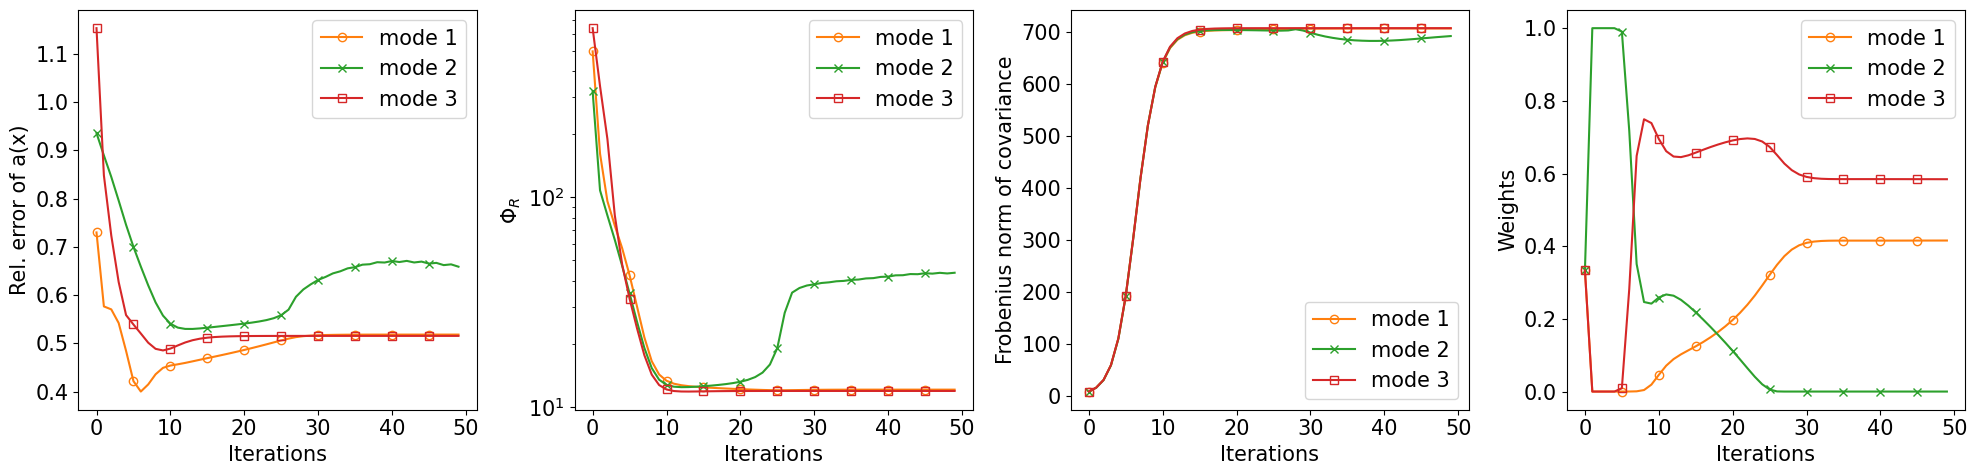

In [56]:
N_ens = 2N_θ + 1
fig, (ax1, ax2, ax3, ax4) = PyPlot.subplots(ncols=4, figsize=(20,5))
ites = Array(LinRange(0, N_iter-1, N_iter))
errors = zeros(Float64, (3, N_iter, N_modes))

for m = 1:N_modes
    for i = 1:N_iter
        if m == N_modes
            logκ_2d_truth = darcy.logκ_2d
        else
            logκ_2d_truth = darcy.logκ_2d[end:-1:1, :]
        end
        errors[1, i, m] = norm(logκ_2d_truth - compute_logκ_2d(darcy, ukiobj.θ_mean[i][m,:]))/norm(darcy.logκ_2d)
        errors[2, i, m] = 0.5*(ukiobj.y_pred[i][m,:] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i][m,:] - ukiobj.y))
        errors[3, i, m] = norm(ukiobj.θθ_cov[i][m,:,:])
    end
end

linestyles = ["o"; "x"; "s"]
markevery = 5
for m = 1: N_modes
    ax1.plot(ites, errors[1, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Rel. error of a(x)")
ax1.legend()

for m = 1: N_modes
    ax2.semilogy(ites, errors[2, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax2.set_xlabel("Iterations")
ax2.set_ylabel(L"\Phi_R")
ax2.legend()

for m = 1: N_modes
    ax3.plot(ites, errors[3, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Frobenius norm of covariance")
ax3.legend()


θ_w = exp.(hcat(ukiobj.logθ_w...))
for m = 1: N_modes
    ax4.plot(ites, θ_w[m, 1:N_iter], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax4.set_xlabel("Iterations")
ax4.set_ylabel("Weights")
ax4.legend()
fig.tight_layout()
fig.savefig("Darcy-2D-convergence.pdf")




## Draw marginal distribution

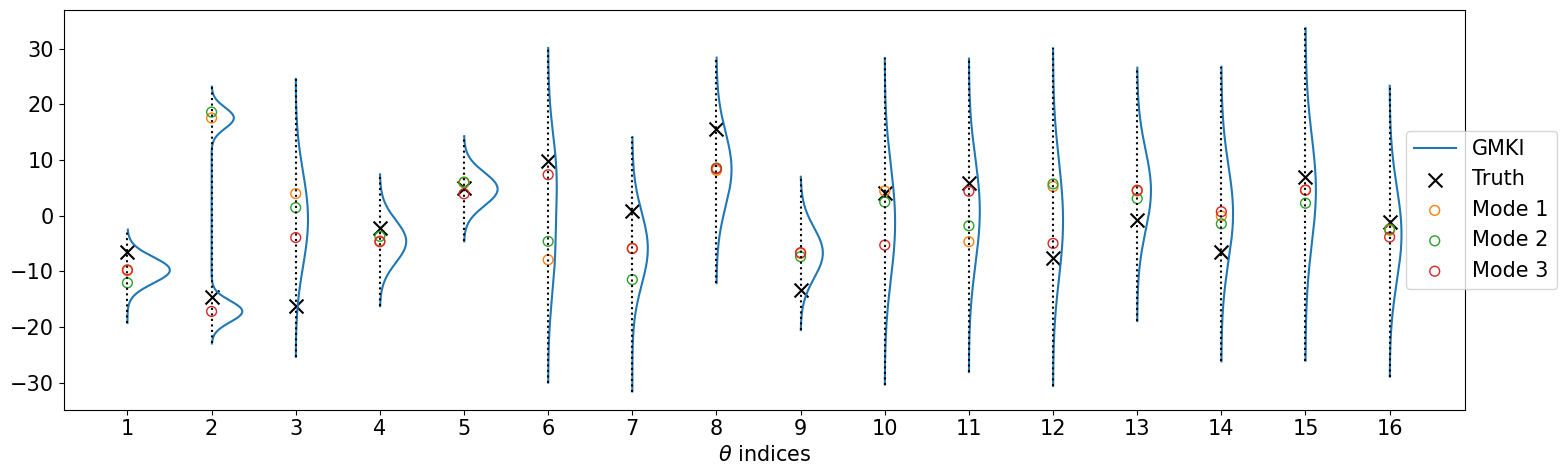

In [57]:
fig, ax = PyPlot.subplots(ncols=1, figsize=(16,5))
θ_ref = darcy.θ_ref

n_ind = 16
θ_ind = Array(1:n_ind)
ax.scatter(θ_ind, θ_ref[θ_ind], s = 100, marker="x", color="black", label="Truth")
for m = 1:N_modes
    ax.scatter(θ_ind, ukiobj.θ_mean[N_iter][m,θ_ind], s = 50, marker="o", color="C"*string(m), facecolors="none", label="Mode "*string(m))
end

Nx = 1000
for i in θ_ind
    θ_min = minimum(ukiobj.θ_mean[N_iter][:,i] .- 3sqrt.(ukiobj.θθ_cov[N_iter][:,i,i]))
    θ_max = maximum(ukiobj.θ_mean[N_iter][:,i] .+ 3sqrt.(ukiobj.θθ_cov[N_iter][:,i,i]))
        
    xxs = zeros(N_modes, Nx)  
    zzs = zeros(N_modes, Nx)  
    for m =1:N_modes
        xxs[m, :], zzs[m, :] = Gaussian_1d(ukiobj.θ_mean[N_iter][m,i], ukiobj.θθ_cov[N_iter][m,i,i], Nx, θ_min, θ_max)
        zzs[m, :] *= exp(ukiobj.logθ_w[N_iter][m]) * 3
    end
    label = nothing
    if i == 1
        label = "GMKI"
    end
    ax.plot(sum(zzs, dims=1)' .+ i, xxs[1,:], linestyle="-", color="C0", fillstyle="none", label=label)
    ax.plot(fill(i, Nx), xxs[1,:], linestyle=":", color="black", fillstyle="none")
        
end
ax.set_xticks(θ_ind)
ax.set_xlabel(L"\theta" * " indices")
ax.legend(loc="center left", bbox_to_anchor=(0.95, 0.5))
fig.tight_layout()
fig.savefig("Darcy-2D-density.pdf")

